# **IMPORTING THE LIBRARIES**


In [ ]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import os
import itertools

# **CONVERTING .MAT FILE TO .CSV FILE**

In [ ]:
# Step 1: Convert .mat file to .csv
def convert_mat_to_csv(mat_file, gt_file, output_csv):
    mat = scipy.io.loadmat(mat_file)
    data = mat['indian_pines']
    ground_truth = scipy.io.loadmat(gt_file)['indian_pines_gt']

    df = pd.DataFrame(data.reshape(data.shape[0] * data.shape[1], -1))
    df.columns = [f'band_{i}' for i in range(1, df.shape[-1] + 1)]
    df['class'] = ground_truth.ravel()
    df.to_csv(output_csv, index=False)



In [ ]:
mat_file = '/content/Indian_pines.mat'
gt_file = '/content/Indian_pines_gt.mat'
csv_file = '/content/ip_csv.csv'
kpca_csv_file = '/content/ip_kpca.csv'
root_dir = '/content/images'

# Convert .mat to .csv
convert_mat_to_csv(mat_file, gt_file, csv_file)


# **DATA PREPROCESSING USING KERNEL PCA**

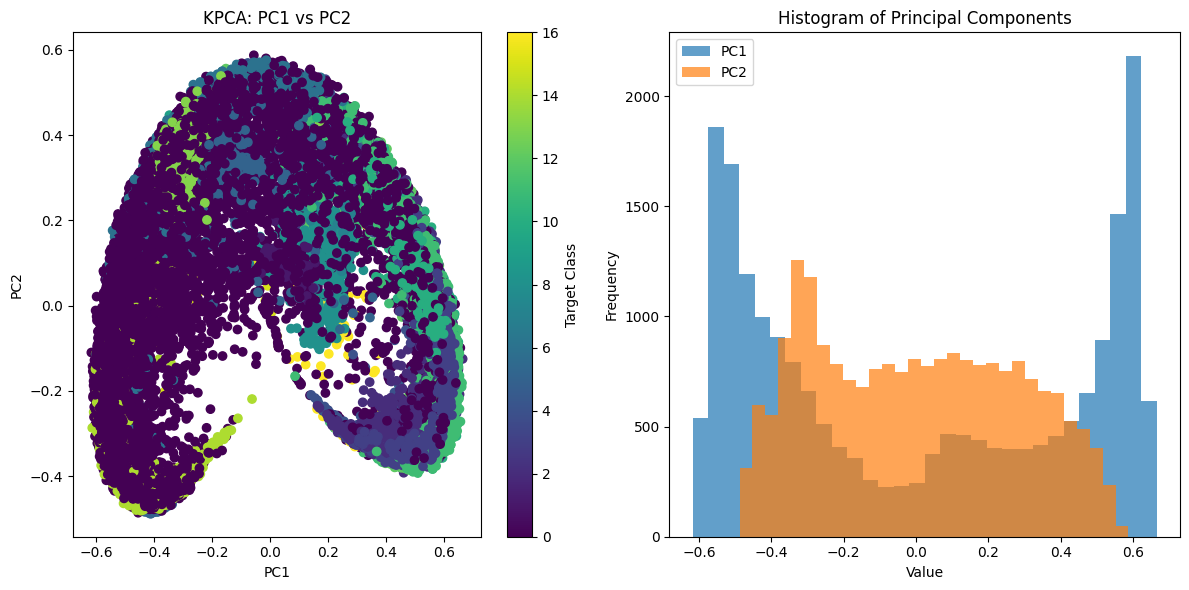

In [ ]:
def preprocess_kpca(csv_file, output_csv):
    # Load the CSV file
    df = pd.read_csv(csv_file)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform KPCA
    kpca = KernelPCA(n_components=2, kernel='rbf')
    X_kpca = kpca.fit_transform(X_scaled)

    # Save KPCA results to CSV
    df_kpca = pd.DataFrame(data=np.hstack((X_kpca, y.reshape(-1, 1))), columns=['PC1', 'PC2', 'target'])
    df_kpca.to_csv(output_csv, index=False)

    # Plot KPCA results
    plt.figure(figsize=(12, 6))

    # Scatter plot of the first two principal components
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(df_kpca['PC1'], df_kpca['PC2'], c=df_kpca['target'], cmap='viridis')
    plt.title('KPCA: PC1 vs PC2')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Target Class')

    # Plot histogram of the principal components
    plt.subplot(1, 2, 2)
    plt.hist(df_kpca['PC1'], bins=30, alpha=0.7, label='PC1')
    plt.hist(df_kpca['PC2'], bins=30, alpha=0.7, label='PC2')
    plt.title('Histogram of Principal Components')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
preprocess_kpca('/content/ip_csv.csv', '/content/ip_kpca.csv')


# **TRAINING THE MODEL WITH CYCLE GAN TECHNIQUE**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.Conv2d(input_nc, 64, 7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.Conv2d(64, output_nc, 7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

    def compute_output_shape(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.forward(dummy_input)
            return output.shape[1:]

# Dataset class for Numpy files
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(root_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        npy_file = np.load(file_path)

        # Convert the numpy array to uint8 and ensure it has 3 dimensions
        if npy_file.ndim == 3 and npy_file.shape[2] == 1:  # Grayscale image
            npy_file = np.repeat(npy_file, 3, axis=2)  # Convert to RGB
        elif npy_file.ndim == 2:  # Single-channel image
            npy_file = np.expand_dims(npy_file, axis=-1)
            npy_file = np.repeat(npy_file, 3, axis=2)  # Convert to RGB
        elif npy_file.ndim == 3 and npy_file.shape[2] == 200:  # Hyperspectral image
            npy_file = npy_file[:, :, :3]  # Take the first 3 channels for RGB

        npy_file = npy_file.astype(np.uint8)  # Convert to uint8

        image = Image.fromarray(npy_file)

        if self.transform:
            image = self.transform(image)

        # Placeholder for labels, replace with actual labels if available
        label = 0
        return image, label

# Example usage:
root_dir = '/content/'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = NpyDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)

torch.Size([2, 3, 256, 256]) torch.Size([2])


In [ ]:
# Step 3: CycleGAN Dataset and Model
def train_cyclegan(root, num_epochs, batch_size, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    dataset = NpyDataset(root, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_nc = 3
    output_nc = 3
    G_A2B = Generator(input_nc, output_nc).to(device)
    G_B2A = Generator(input_nc, output_nc).to(device)
    D_A = Discriminator(input_nc).to(device)
    D_B = Discriminator(input_nc).to(device)

    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    optimizer_G = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

    # Compute the output shapes for real and fake labels dynamically
    real_A = next(iter(dataloader))[0].to(device)
    output_shape_D_A = D_A.compute_output_shape(real_A.shape[1:])
    output_shape_D_B = D_B.compute_output_shape(real_A.shape[1:])

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_A = batch[0].to(device)
            real_B = batch[0].to(device)

            valid = torch.ones(real_A.size(0), *output_shape_D_A).to(device)
            fake = torch.zeros(real_A.size(0), *output_shape_D_A).to(device)

            # Generators A2B and B2A
            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_B2A(real_A), real_A)
            loss_id_B = criterion_identity(G_A2B(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_A2B(real_A)
            loss_GAN_A2B = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_B2A(real_B)
            loss_GAN_B2A = criterion_GAN(D_A(fake_A), valid)

            loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

            # Cycle loss
            recov_A = G_B2A(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_A2B(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

            loss_G.backward()
            optimizer_G.step()

            # Discriminator A
            optimizer_D_A.zero_grad()

            loss_real_A = criterion_GAN(D_A(real_A), valid)
            loss_fake_A = criterion_GAN(D_A(fake_A.detach()), fake)
            loss_D_A = (loss_real_A + loss_fake_A) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # Discriminator B
            optimizer_D_B.zero_grad()

            loss_real_B = criterion_GAN(D_B(real_B), valid)
            loss_fake_B = criterion_GAN(D_B(fake_B.detach()), fake)
            loss_D_B = (loss_real_B + loss_fake_B) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{len(dataloader)}] '
                  f'Loss G: {loss_G.item():.4f} Loss D_A: {loss_D_A.item():.4f} Loss D_B: {loss_D_B.item():.4f}')

    torch.save(G_A2B.state_dict(), 'G_A2B.pth')
    torch.save(G_B2A.state_dict(), 'G_B2A.pth')
    torch.save(D_A.state_dict(), 'D_A.pth')
    torch.save(D_B.state_dict(), 'D_B.pth')




In [ ]:
# Train CycleGAN
root_dir = '/content/'
num_epochs = 5
batch_size = 32
lr = 0.0002

train_cyclegan(root_dir, num_epochs, batch_size, lr)


Epoch [1/5] Batch [1/1] Loss G: 7.3434 Loss D_A: 0.7097 Loss D_B: 0.5657
Epoch [2/5] Batch [1/1] Loss G: 5.1539 Loss D_A: 1.0535 Loss D_B: 1.0395
Epoch [3/5] Batch [1/1] Loss G: 4.4154 Loss D_A: 0.6378 Loss D_B: 0.6325
Epoch [4/5] Batch [1/1] Loss G: 4.4226 Loss D_A: 0.6051 Loss D_B: 0.3498
Epoch [5/5] Batch [1/1] Loss G: 4.9341 Loss D_A: 0.6954 Loss D_B: 0.6119


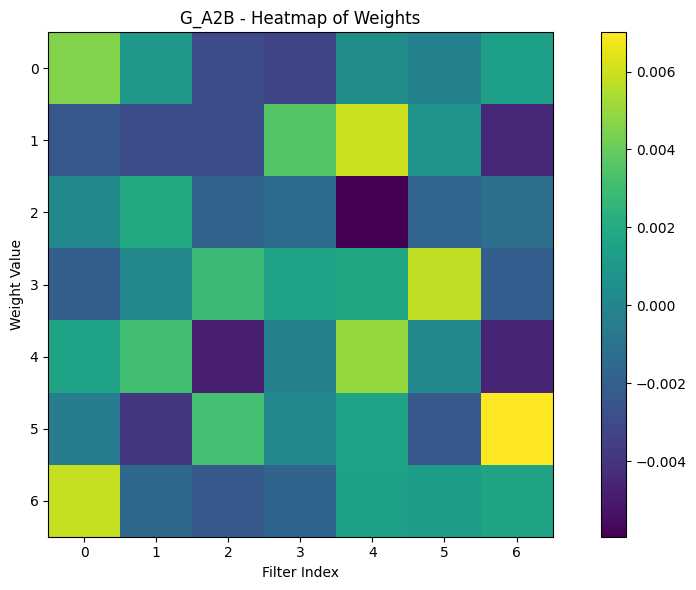

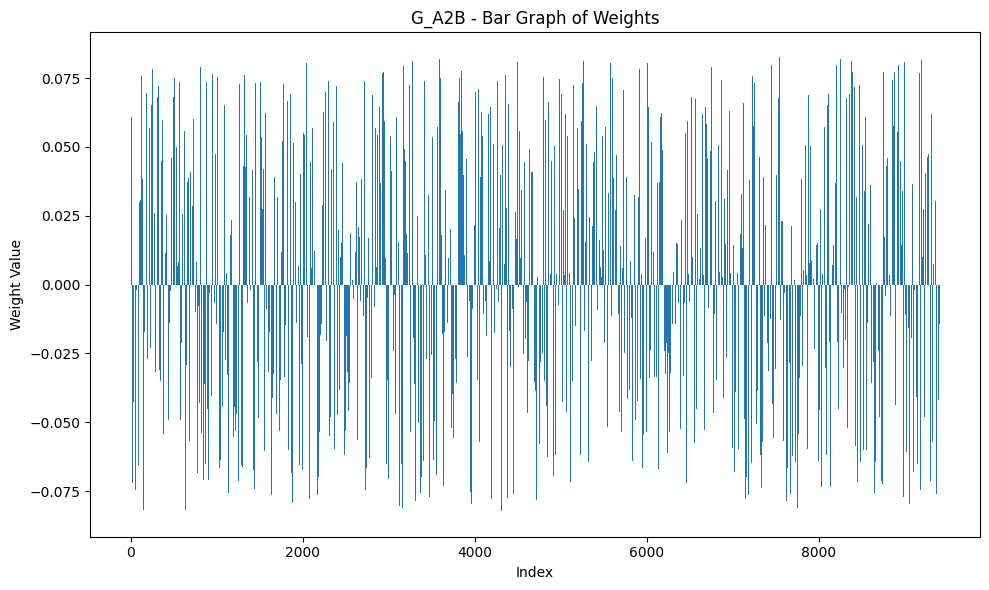

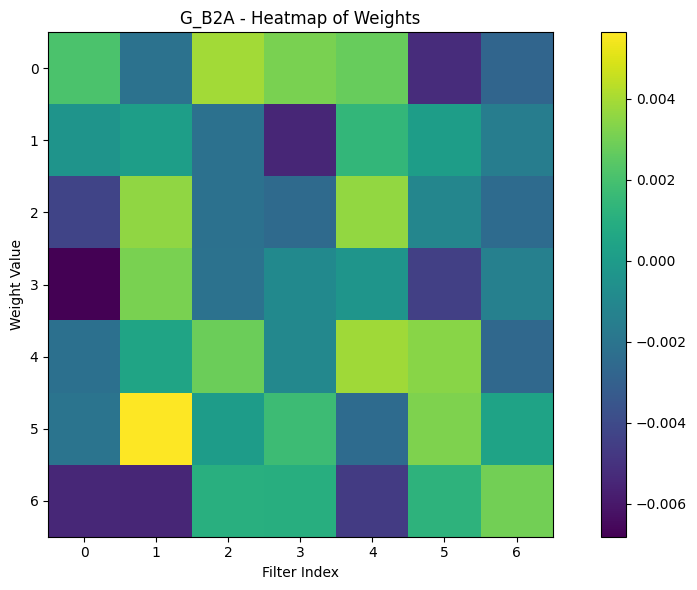

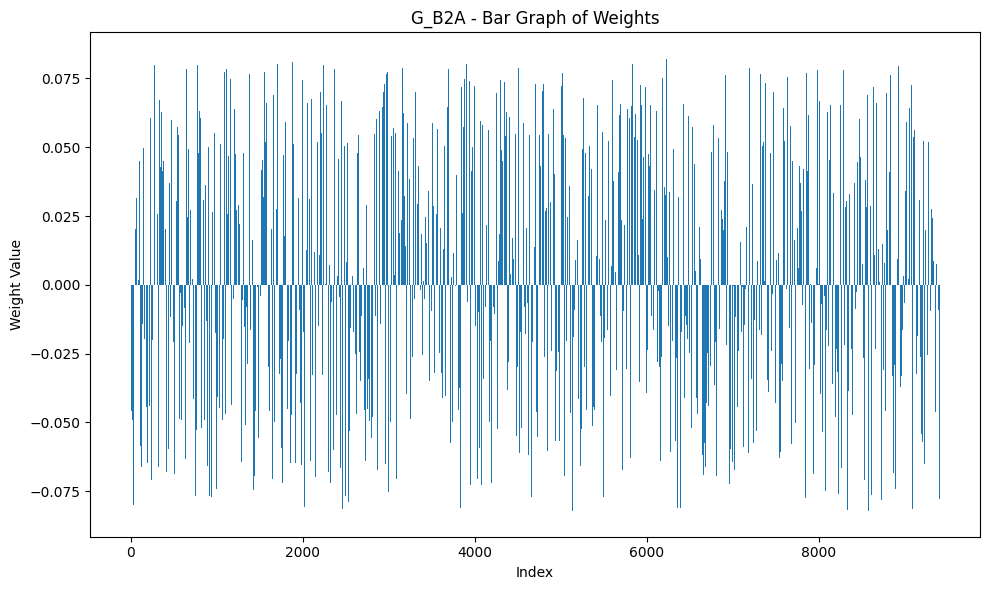

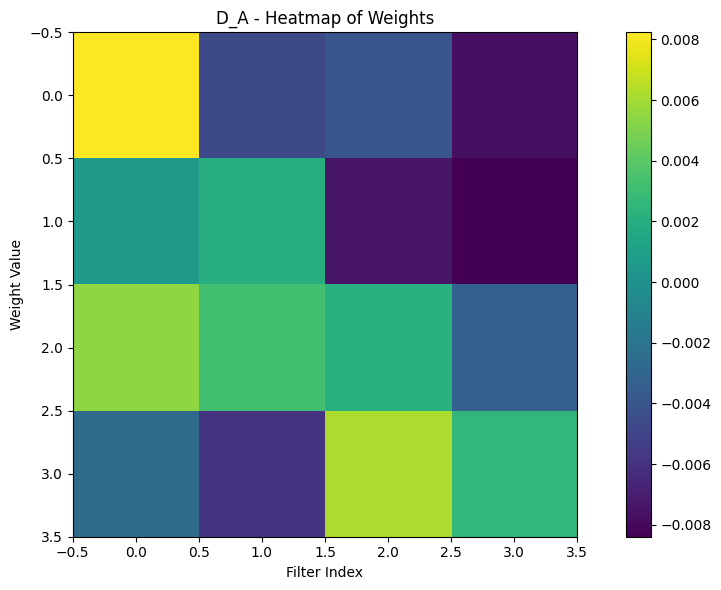

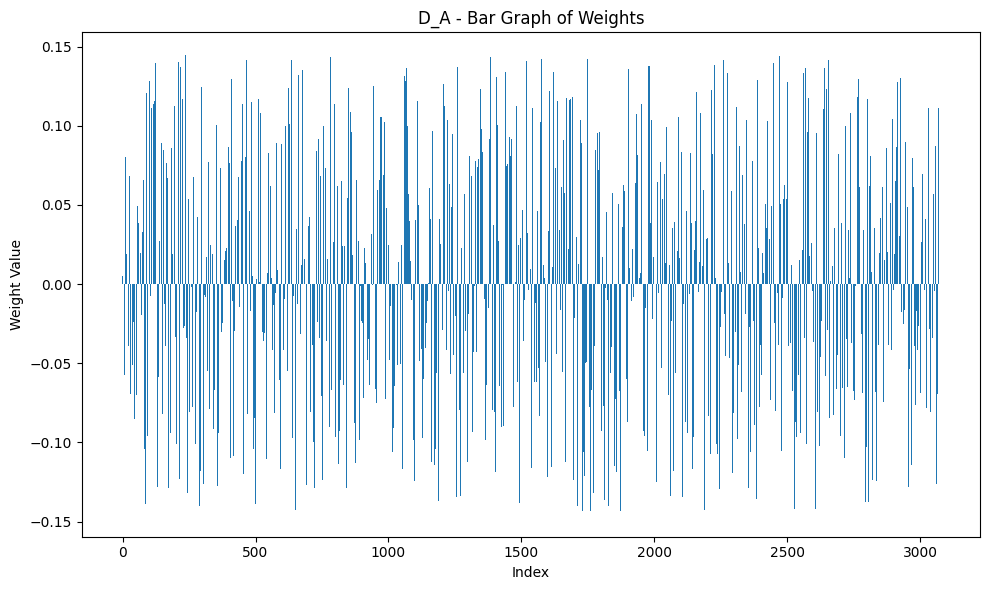

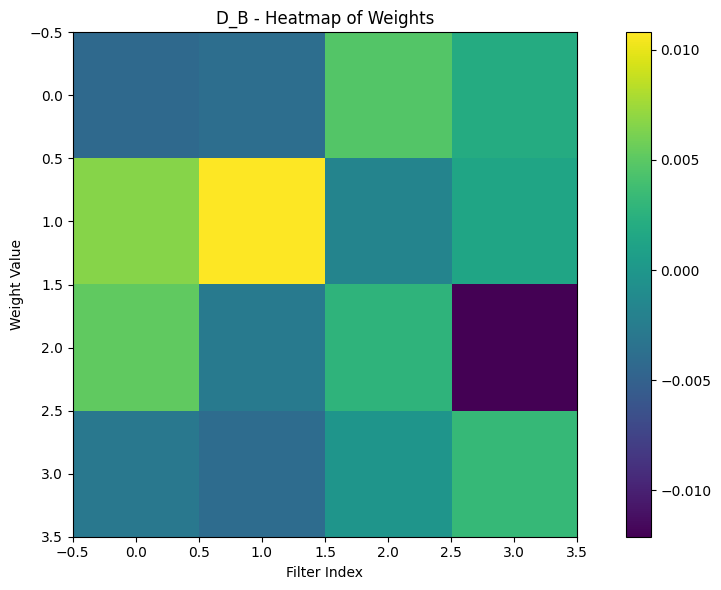

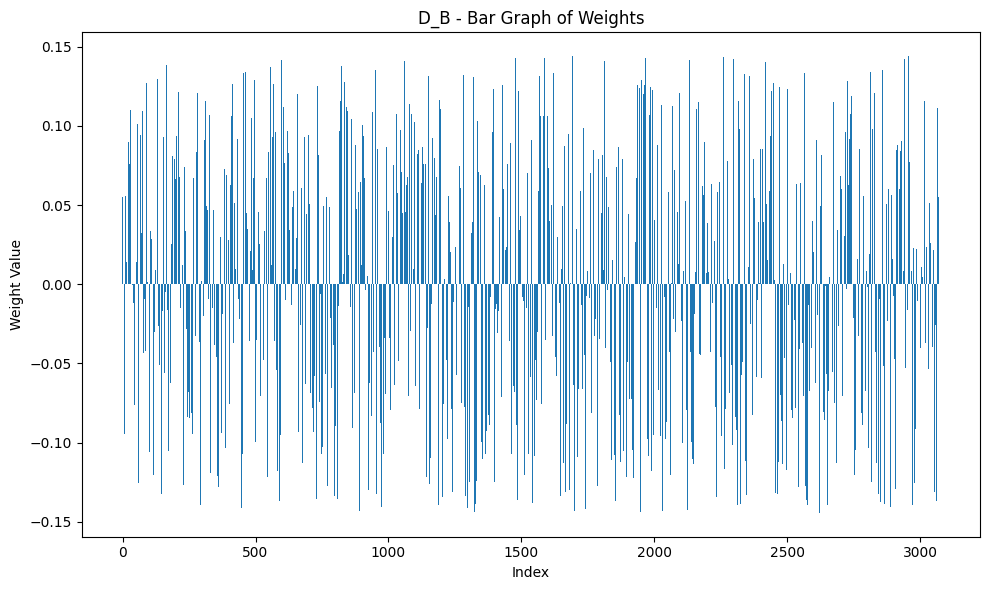

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_model_weights_heatmap(model_path, model_name):
    # Load model weights
    model_weights = torch.load(model_path)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract a representative weight (assuming weights are in conv layers)
    for name, weight in model_weights.items():
        if len(weight.shape) > 2:  # For convolutional layers
            weight = weight.mean(dim=0).mean(dim=0)  # Average across channels
            break
    else:
        weight = list(model_weights.values())[0].reshape(-1, 1)  # Fallback

    cax = ax.imshow(weight.cpu().numpy(), cmap='viridis')
    ax.set_title(f'{model_name} - Heatmap of Weights')
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Weight Value')

    # Add colorbar
    fig.colorbar(cax, ax=ax)

    plt.tight_layout()
    plt.show()

def plot_model_weights_bar(model_path, model_name):
    # Load model weights
    model_weights = torch.load(model_path)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Flatten and get a representative weight
    for name, weight in model_weights.items():
        if len(weight.shape) > 2:  # For convolutional layers
            weight = weight.view(-1).cpu().numpy()  # Flatten and convert to numpy
            break
    else:
        weight = list(model_weights.values())[0].view(-1).cpu().numpy()  # Fallback

    ax.bar(np.arange(len(weight)), weight)
    ax.set_title(f'{model_name} - Bar Graph of Weights')
    ax.set_xlabel('Index')
    ax.set_ylabel('Weight Value')

    plt.tight_layout()
    plt.show()

# File paths
model_paths = {
    'G_A2B': 'G_A2B.pth',
    'G_B2A': 'G_B2A.pth',
    'D_A': 'D_A.pth',
    'D_B': 'D_B.pth'
}

# Plot heatmap and bar graph for each model
for model_name, path in model_paths.items():
    plot_model_weights_heatmap(path, model_name)
    plot_model_weights_bar(path, model_name)


# **TESTING THE MODEL USING EFFICIENT NET TECHNIQUE**

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

class NumpyDataset(Dataset):
    def __init__(self, npy_file, transform=None):
        self.data = np.load(npy_file)  # Assuming the npy file contains data in the form (num_samples, height, width, channels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = self.data[idx]

        # Convert from uint16 to uint8 if necessary
        if image_data.dtype == np.uint16:
            image_data = (image_data / 256).astype(np.uint8)  # Normalize to [0, 255] and convert to uint8

        if len(image_data.shape) == 2:  # Grayscale image
            image_data = np.expand_dims(image_data, axis=-1)  # Add channel dimension

        if image_data.shape[2] == 1:  # Single channel
            image_data = np.repeat(image_data, 3, axis=-1)  # Convert grayscale to RGB by repeating channels

        image = Image.fromarray(image_data, 'RGB')

        if self.transform:
            image = self.transform(image)

        return image

def test_model(npy_file, model_path, num_classes):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor()  # Convert to tensor
    ])

    dataset = NumpyDataset(npy_file, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    model = models.efficientnet_b0(weights='DEFAULT')  # Load EfficientNet with default weights
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust classifier layer

    # Load model weights if needed
    # model.load_state_dict(torch.load(model_path))  # Uncomment if using custom weights

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            # Append dummy labels if true labels are not available
            dummy_labels = np.random.randint(0, num_classes, size=len(preds))
            all_labels.extend(dummy_labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Ensure predictions and labels are valid and aligned
    if len(all_preds) == 0 or len(all_labels) == 0:
        print("No predictions or labels available.")
        return

    accuracy = accuracy_score(all_labels, all_preds)

    try:
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        roc_auc = roc_auc_score(np.eye(num_classes)[all_labels], np.eye(num_classes)[all_preds], multi_class='ovr')
    except ValueError as e:
        precision = recall = roc_auc = float('nan')
        print(f"Metric calculation error: {e}")

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

# Example usage
test_model('/content/indianpinearray.npy', '/content/G_A2B.pth', num_classes=16)


Accuracy: 0.0552
Precision: 0.0374
Recall: 0.0552
ROC AUC: 0.4950
